# Analysis of long-read transcriptomes

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import anndata
import scipy.stats as st
import statsmodels.stats as stm
from statsmodels.stats.multitest import multipletests
import swan_vis as swan
from matplotlib.colors import ListedColormap
import matplotlib as mpl

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### Data pre-processing

Run Minimap2, TranscriptClean, and TALON using `run_talon_tc.sh`

Create TALON abundance file
```bash 
db=talon/pgp1.db
talon_abundance \
    --db $db \
    -a gencode_v29 \
    -b hg38 \
    --o talon/pgp1
```

Filter novel transcripts for reproducibility
```bash
db=talon/pgp1.db
talon_filter_transcripts \
    --db $db \
    -a gencode_v29 \
    --maxFracA=0.5 \
    --minCount=5 \
    --minDatasets=2 \
    --o talon/pgp1_pass_list.csv
```

In [40]:
def get_talon_nov_colors():
    c_dict = {'Known': '#009E73',
              'ISM': '#0072B2',
              'NIC': '#D55E00',
              'NNC': '#E69F00',
              'Antisense': '#000000',
              'Intergenic': '#CC79A7',
              'Genomic': '#F0E442'}
    order = ['Known', 'ISM', 'NIC', 'NNC', 'Antisense', 'Intergenic', 'Genomic']
    
    return c_dict, order

def add_perc(ax, data, feature):
    total = data[feature].sum()
    ylim = ax.get_ylim()[1]
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.4
        y = p.get_y() + p.get_height() + ylim*0.00625
        ax.annotate(percentage, (x, y), size = 14)
        
def plot_read_novelty(df, opref, c_dict, order,
                      ylim=None, title=None, 
                      datasets='all'):
    sns.set_context("paper", font_scale=1.6)
    sns.set_style(style='white')
    
    
    temp = df.copy(deep=True)
    
    # filter on datasets
    if datasets != 'all':
        temp = temp.loc[temp.dataset.isin(datasets)]        
    
    # count number of reads per cat
    temp = temp[['transcript_novelty', 'read_name']].groupby('transcript_novelty').count()
    temp.reset_index(inplace=True)
    temp.rename({'read_name':'counts'}, axis=1, inplace=True)
    print(temp)
    
    # actual plotting
    g = sns.catplot(data=temp, x='transcript_novelty',
                y='counts', kind='bar', 
                palette=c_dict, order=order)
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    g.set_ylabels('Reads')
    g.set_xlabels('Transcript novelty')
    
    # add percentage labels
    ax = g.axes[0,0]
    add_perc(ax, temp, 'counts')
    
    if ylim:
        g.set(ylim=(0,ylim))
    
#     # add title
#     if not title:
#         g.fig.suptitle('Reads per novelty category')
#     else:
#         g.fig.suptitle('{} reads per novelty category'.format(title))
        
    # save figure
    fname = '{}_read_novelty'.format(opref)
    g.savefig(fname+'.pdf', dpi=300)
    
def plot_transcript_novelty(df, oprefix, c_dict, order, \
                            ylim=None, title=None,
                            whitelist=None, datasets='all', save_type='pdf'):
    sns.set_context('paper', font_scale=1.6)
    sns.set_style(style='white')
    
    temp = df.copy(deep=True)
    
    # remove transcripts that are not on whitelist
    if whitelist:
        temp = temp.loc[temp.transcript_ID.isin(whitelist)]
    
    # filter on datasets
    if datasets != 'all':
        temp = temp.loc[temp.dataset.isin(datasets)]        
    
    # count number of isoforms per cat
    temp = temp[['transcript_ID', 'transcript_novelty', 'read_name']].groupby(['transcript_ID', 'transcript_novelty']).count()
    temp.reset_index(inplace=True)
    temp.drop('read_name', axis=1, inplace=True)
    temp = temp.groupby('transcript_novelty').count()
    temp.reset_index(inplace=True)
    temp.rename({'transcript_ID': 'counts'}, axis=1, inplace=True)
    print(temp)
    
    # actual plotting
    g = sns.catplot(data=temp, x='transcript_novelty',
                y='counts', kind='bar', 
                palette=c_dict, order=order)
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    g.set_ylabels('Isoforms')
    g.set_xlabels('Transcript novelty')
    
    # add percentage labels
    ax = g.axes[0,0]
    add_perc(ax, temp, 'counts')
    
    if ylim:
        g.set(ylim=(0,ylim))
    
#     # add title
#     if not title:
#         g.fig.suptitle('Transcript models per novelty category')
#     else:
#         g.fig.suptitle('{} transcript models per novelty category'.format(title))
        
    # save figure
    fname = '{}_isoform_novelty'.format(oprefix)
    if save_type == 'png':
        g.savefig(fname+'.png', dpi=300)        
    elif save_type == 'pdf':
        g.savefig(fname+'.pdf', dpi=300)        
    
    plt.show()
    plt.clf()

  transcript_novelty   counts
0          Antisense   137767
1            Genomic   143842
2                ISM   393877
3         Intergenic    16599
4              Known  3068807
5                NIC   180012
6                NNC   109720


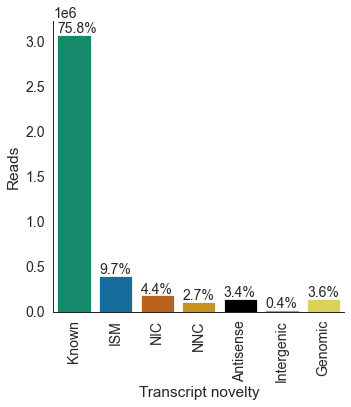

In [41]:
df = pd.read_csv('talon/pgp1_talon_read_annot.tsv', sep='\t')
c_dict, order = get_talon_nov_colors()
datasets = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
opref = 'pgp1'
plot_read_novelty(df, opref, c_dict, order,
                      ylim=None, title=None, 
                      datasets=datasets)

  transcript_novelty  counts
0          Antisense   34773
1            Genomic   33150
2                ISM   83895
3         Intergenic    8044
4              Known   36205
5                NIC   67933
6                NNC   64771


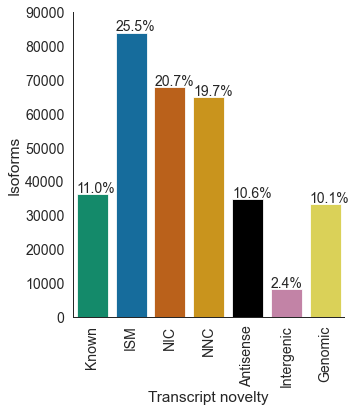

<Figure size 432x288 with 0 Axes>

In [43]:

# unfiltered
df = pd.read_csv('talon/pgp1_talon_read_annot.tsv', sep='\t')
c_dict, order = get_talon_nov_colors()
datasets = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
opref = 'pgp1'
pass_list = pd.read_csv('talon/pgp1_pass_list.csv', header=None, names=['gene_ID', 'transcript_ID'])
plot_transcript_novelty(df, opref, c_dict, order, \
                            ylim=90000, title='Unfiltered', datasets='all', save_type='pdf')

  transcript_novelty  counts
0          Antisense     414
1                ISM    2058
2         Intergenic      32
3              Known   36205
4                NIC    1108
5                NNC     414


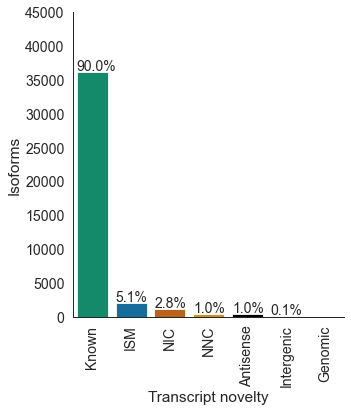

<Figure size 432x288 with 0 Axes>

In [44]:
# filtered
df = pd.read_csv('talon/pgp1_talon_read_annot.tsv', sep='\t')
c_dict, order = get_talon_nov_colors()
datasets = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
opref = 'pgp1'
pass_list = pd.read_csv('talon/pgp1_pass_list.csv', header=None, names=['gene_ID', 'transcript_ID'])
pass_list = pass_list.transcript_ID.unique().tolist()
plot_transcript_novelty(df, opref, c_dict, order, \
                            ylim=45000, title='Filtered',
                            whitelist=pass_list, datasets='all', save_type='pdf')

In [11]:
print('Total reads')
print(len(df.index))

Total reads
4050624


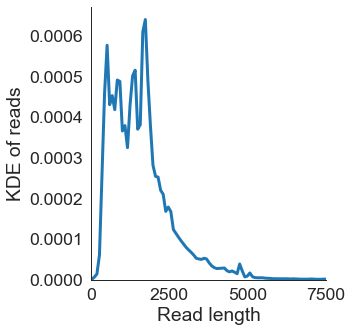

In [42]:
sns.set_context('paper', font_scale=2)    
    
ax = sns.displot(data=df, x='read_length', kind='kde', linewidth=3)
ax.set(xlabel='Read length', ylabel='KDE of reads',
      title='', xlim=(0,7500),
      xticks=[0, 2500, 5000, 7500])
plt.savefig('{}_read_length_kde.pdf'.format(opref), dpi=300, bbox_inches='tight')

### TSS

Isolate reads that represent more confident 5' ends.

In [2]:
import pandas as pd
import swan_vis as swan

In [3]:
annot = 'talon/pgp1_talon_read_annot.tsv'

In [4]:
# limit the reads to those that represent putative 5' ends
df = pd.read_csv(annot, sep='\t')
tss_df = df.loc[df.transcript_novelty.isin(['Known', 'NIC', 'NNC', 'ISM'])]
tss_df = tss_df.loc[tss_df.ISM_subtype.isin(['None', 'Prefix', 'Both'])]
tss_reads = tss_df.read_name.tolist()

# tss
fname = 'tss_read_names.txt'
with open(fname, 'w') as ofile:
    for r in tss_reads:
        ofile.write(r+'\n')

Create a sam file with all the TSS reads from the merged BAM using picard tools `isolate_tss_reads.sh`

Call TSSs using Diane's script
```bash
tss_dir=~/mortazavi_lab/bin/tss-annotation/long_read/
python ${tss_dir}pacbio_to_tss.py \
    -i tss_reads.bam \
    --window-size=50 \
    --expression-threshold=2 \
    -o unfilt_tss.bed \
    -r \
    -n rev_tss.bw \
    -p fwd_tss.bw
```

Get the read names associated with each TSS as well 
```bash
python ${tss_dir}tss_reads.py \
    -i talon_tmp/merged.bam \
    -r unfilt_tss.bed \
    -o tss_reads.bed
```

In [302]:
# filter a list of TSSs for each gene
annot = 'talon/pgp1_talon_read_annot.tsv'
tss_reads = 'tss_reads.bed'

df = pd.read_csv(annot, sep='\t')

# remove sirvs and erccs
df = df.loc[~df.chrom.str.contains('SIRV')]
df = df.loc[~df.chrom.str.contains('ERCC')]

# print('Before assigning each read a TSS')
# print(len(df.index))
ends = pd.read_csv(tss_reads, sep='\t', header=None,
            names=['chrom', 'start', 'end', 'read_name', 'tss_id', 'strand'])

# merge on read name
df = df.merge(ends, how='inner', on='read_name')

# groupby on gene and tss
df = df[['read_name', 'annot_gene_name', 'tss_id']].groupby(['annot_gene_name', 'tss_id']).count()

# filter tsss for those that have >10% of the reads
# for the most highly-expressed tss of the gene
df.reset_index(inplace=True)
df.rename({'read_name':'count'}, axis=1, inplace=True)
temp = df.loc[df.apply(lambda x: x['count'] >= df.loc[df.annot_gene_name==x.annot_gene_name, 'count'].max()*0.1, axis=1)]

temp.loc[temp.annot_gene_name == 'MBP']

#, assign each TSS a name, and quantify TSS exp
temp.sort_values(by=['annot_gene_name'], inplace=True)
temp['tss_id_2'] = np.nan
prev_gene = None
for ind, entry in temp.iterrows():
    curr_gene = entry.annot_gene_name
    if curr_gene != prev_gene:
        i = 1
    else:
        i += 1
    prev_gene = curr_gene
    temp.loc[ind, 'tss_id_2'] = '{}_{}'.format(curr_gene, i)
    
# merged called TSSs back in with read annot
df = pd.read_csv(annot, sep='\t')
ends = pd.read_csv(tss_reads, sep='\t', header=None,
            names=['chrom', 'start', 'end', 'read_name', 'tss_id', 'strand'])
ends = ends[['read_name', 'tss_id']]

# dump filtered TSSs to bed 
fname = 'unfilt_tss.bed'
end_regions = pd.read_csv(fname, sep='\t', header=None,
            names=['chrom', 'start', 'end', 'tss_id', 'read_count', 'strand', 
                   'sth1', 'sth2', 'sth3', 'sth4', 'sth5'])
print(temp.head())
print(temp.tss_id.dtypes)
print(end_regions.head())
print(end_regions.tss_id.dtypes)
filt_ends = end_regions.merge(temp[['tss_id', 'tss_id_2']], how='inner', on='tss_id')
print(filt_ends.head())
filt_ends['score'] = 0
filt_ends = filt_ends[['chrom', 'start', 'end', 'tss_id_2', 'score', 'strand']]
fname = 'filt_tss.bed'
filt_ends.to_csv(fname, sep='\t', header=None, index=False)

# merge on read name
df = df.merge(ends, how='inner', on='read_name')
temp = temp[['annot_gene_name', 'tss_id', 'tss_id_2']]
df = df.merge(temp, how='inner', on=['annot_gene_name', 'tss_id'])

# format like talon ab
cols = ['annot_gene_name', 'annot_gene_id', 'dataset', 'tss_id_2']
df = df[cols+['read_name']].groupby(cols).count().reset_index()
df.rename({'read_name':'counts', 'tss_id_2':'tss_id'}, axis=1, inplace=True)
df = df.pivot(index=['annot_gene_name', 'annot_gene_id', 'tss_id'], columns='dataset', values='counts')
df.reset_index(inplace=True)
df = df.rename_axis(None, axis=1)
df.fillna(0, inplace=True)

# i guess sum over genes with the same name smh
df.drop('annot_gene_id', axis=1, inplace=True)
df = df.groupby(['annot_gene_name', 'tss_id']).sum().reset_index()

print(len(df.index))
print(len(df.columns))
df.to_csv('pgp1_tss_talon_abundance.tsv', sep='\t', index=False)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

  annot_gene_name                                           tss_id  count  \
0            A1BG         m54284U_210303_010717/56821818/ccs_11277     70   
1        A1BG-AS1  m54284_190620_121340/10027666/31_1705_CCS_11278     68   
2             A2M   m54284_190620_121340/62456306/4696_57_CCS_4485     43   
4          A4GALT  m54284_190620_121340/71565601/31_2054_CCS_14051     38   
5            AAAS   m54284_190612_161714/42402034/31_1873_CCS_4799    185   

     tss_id_2  
0      A1BG_1  
1  A1BG-AS1_1  
2       A2M_1  
4    A4GALT_1  
5      AAAS_1  
object
        chrom  start  end                                 tss_id  read_count  \
0  ERCC-00003      1    9  m54284U_210303_010717/143917151/ccs_0           3   
1  ERCC-00004      1   20  m54284U_210303_010717/151193504/ccs_1          14   
2  ERCC-00009      1   54  m54284U_210304_072206/177472309/ccs_2           2   
3  ERCC-00022      1   18   m54284U_210303_010717/34668868/ccs_3           1   
4  ERCC-00035      1   53  m54284U

Make the filtered TSS file into a bigBed file that can be displayed on the genome browser
```bash
bed='filt_tss.bed'
chrom_sizes='~/mortazavi_lab/ref/hg38/hg38.chrom.sizes'
bedToBigBed \
    $bed \
    $chrom_sizes \
    filt_tss.bb
```

### Swan

Swan config file

In [17]:
annot = '/Users/fairliereese/mortazavi_lab/ref/gencode.v29/gencode.v29.SIRV.ERCC.annotation.gtf'

# initialize SwanGraph
sg = swan.SwanGraph()

# add annotation GTF for reference
sg.add_annotation(annot)

# add transcript models from each dataset
sg.add_datasets('swan_config.tsv')

sg.save_graph('swan')


Adding dataset annotation to the SwanGraph

Adding dataset astro_1 to the SwanGraph

Adding dataset astro_2 to the SwanGraph

Adding dataset excite_neuron_1 to the SwanGraph

Adding dataset excite_neuron_2 to the SwanGraph

Adding dataset pgp1_1 to the SwanGraph

Adding dataset pgp1_2 to the SwanGraph
Saving graph as swan.p


In [47]:
# detect IR and ES
g_es, t_es, e_es = sg.find_es_genes()
g_ir, t_ir, e_ir = sg.find_ir_genes()

Analyzing 752 intronic edges for ES
Found 231 novel es events in 259 transcripts.
Analyzing 2184 exonic edges for IR
Found 65 novel ir events from 71 transcripts.


In [48]:
# plot gene summary graph for a gene with IR
g_ir[:5]

['ENSG00000031698.12',
 'ENSG00000173267.13',
 'ENSG00000229117.8',
 'ENSG00000161203.13',
 'ENSG00000092199.17']

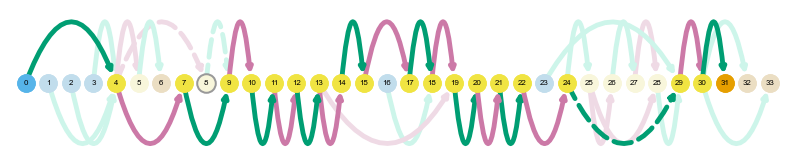

Saving summary graph for ENSG00000031698.12 as figures/SARS_novel_ENSG00000031698.12_summary.png


In [65]:
sg = swan.SwanGraph('swan.p')
sg.plot_graph('SARS', indicate_novel=True, display=True, prefix='figures/SARS')

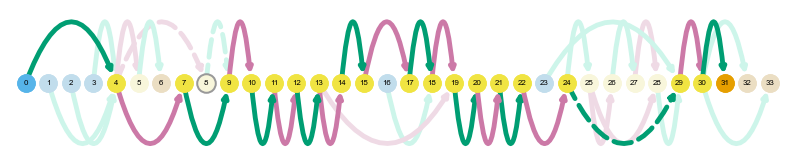

Saving transcript path graph for ENCODEHT000445064 as figures/SARS_novel_ENCODEHT000445064_path.png


In [64]:
sg.plot_transcript_path('ENCODEHT000445064', indicate_novel=True, display=True, prefix='figures/SARS')

In [56]:
gname = 'SARS'
sg.gen_report(gname, prefix='figures/{}'.format(gname),
    heatmap=True, 
    cmap='viridis', 
    indicate_novel=True,
    novelty=True)
sg.gen_report(gname, prefix='figures/{}'.format(gname),
    heatmap=True, 
    cmap='viridis', 
    browser=True,
    novelty=True)


Plotting transcripts for ENSG00000031698.12
Saving transcript path graph for ENST00000234677.6 as figures/SARS_novel_ENST00000234677.6_path.png
Saving transcript path graph for ENST00000369923.4 as figures/SARS_novel_ENST00000369923.4_path.png
Saving transcript path graph for ENCODEHT000444845 as figures/SARS_novel_ENCODEHT000444845_path.png
Saving transcript path graph for ENST00000482384.1 as figures/SARS_novel_ENST00000482384.1_path.png
Saving transcript path graph for ENCODEHT000445064 as figures/SARS_novel_ENCODEHT000445064_path.png
Saving transcript path graph for ENST00000468588.1 as figures/SARS_novel_ENST00000468588.1_path.png
Generating report for ENSG00000031698.12

Plotting transcripts for ENSG00000031698.12
Saving transcript path graph for ENST00000234677.6 as figures/SARS_browser_ENST00000234677.6_path.png
Saving transcript path graph for ENST00000369923.4 as figures/SARS_browser_ENST00000369923.4_path.png
Saving transcript path graph for ENCODEHT000444845 as figures/SAR

### TSS switching

In [2]:
# df: talon abundance file (either tss or transcript)
# cond_map: dictionary of {condition: [dataset1, dataset2]}; how you want to group datasets
# how: whether to make a tss or iso level adata; 'tss' or 'iso'
# pass_list: if 'iso', file of valid transcript IDs that pass filtering
def make_adata(df, cond_map, how='iso', pass_list=None):
    
    # filter talon ab file based on pass list
#     df = pd.read_csv(ab_file, sep='\t')
    if pass_list:
        pass_list = pd.read_csv(pass_list, header=None, names=['gene_id', 'transcript_id'])
        df = df.loc[df.transcript_ID.isin(pass_list.transcript_id.tolist())]

    # obs table
    obs = pd.DataFrame.from_dict(cond_map, orient='index')
    obs.reset_index(inplace=True)
    id_vars = ['index']
    value_vars = obs.columns[1:]
    obs = obs.melt(id_vars=id_vars, value_vars=value_vars)
    obs.drop('variable', axis=1, inplace=True)
    obs.rename({'index':'condition', 'value':'dataset'}, axis=1, inplace=True)

    # var table
    if how=='iso':
        var_cols = ['annot_transcript_name', 'annot_gene_name',\
                    'annot_transcript_id', 'annot_gene_id', \
                    'gene_ID', 'transcript_ID', 'transcript_novelty', \
                    'ISM_subtype']
        var = df[var_cols]
        var.rename({'transcript_ID':'transcript_id', \
                    'gene_ID':'gene_id',\
                    'annot_gene_name': 'gene_name'}, axis=1, inplace=True)
    if how=='tss': 
        var_cols = ['annot_gene_name', 'tss_id']
        var = df[var_cols]
        var.rename({'annot_gene_name': 'gene_name'}, axis=1, inplace=True)
        
    # X table
    df = df.transpose()
    df = df.loc[df.index.isin(obs.dataset.tolist())]
    obs_order = obs['dataset'].reset_index().set_index('dataset')
    df['dataset_num'] = df.index.map(obs_order['index'])
    df.sort_values('dataset_num', inplace=True)
    df.drop('dataset_num', axis=1, inplace=True)
    X = df.to_numpy()

    adata = anndata.AnnData(obs=obs, var=var, X=X) 
    
    return adata

# gene_df: pandas dataframe with expression values in each condition for each TSS in a gene
# conditions: list of str of condition names
# rc: threshold of read count per gene in each condition necessary to test this gene
def test_gene(gene_df, conditions, col, id_col, rc=10):
    
    gene_df = gene_df.pivot(index=col, columns=id_col, values='counts')
    gene_df = gene_df.transpose()
    
    groups = gene_df.columns.tolist()
    gene_df['total_counts'] = gene_df[groups].sum(axis=1)
    gene_df.sort_values(by='total_counts', ascending=False, inplace=True)

    if len(gene_df.index) > 11:
        gene_df.reset_index(inplace=True)

        beep = gene_df.iloc[10:].sum()
        beep[id_col] = 'all_other'
        beep.index.name = None  
        beep = pd.DataFrame(beep).transpose()

        gene_df = gene_df.iloc[:10]
        gene_df = pd.concat([gene_df, beep])  
        
    # limit to just isoforms with > 0 expression in both conditions
    cond1 = conditions[0]
    cond2 = conditions[1]
    gene_df = gene_df.loc[(gene_df[cond1]>0)&(gene_df[cond2]>0)]
    
    # does this gene reach the desired read count threshold?
    for cond in conditions:
        if gene_df[cond].sum() < rc:
            return np.nan, np.nan
    
    # only do the rest if there's nothing left
    if gene_df.empty:
        return np.nan, np.nan
    
    # calculate the percent of each sample each TSS accounts for
    cond_pis = []
    for cond in conditions:
        total_col = '{}_total'.format(cond)
        pi_col = '{}_pi'.format(cond)
        total_count = gene_df[cond].sum()

        cond_pis.append(pi_col)

        gene_df[total_col] = total_count
        gene_df[pi_col] = (gene_df[cond]/gene_df[total_col])*100
        
    # compute isoform-level and gene-level delta pis
    gene_df['dpi'] = gene_df[cond_pis[0]] - gene_df[cond_pis[1]]
    gene_df['abs_dpi'] = gene_df.dpi.abs()
    gene_dpi = gene_df.iloc[:2].abs_dpi.sum()    
    
    # chi squared test 
    chi_table = gene_df[conditions].to_numpy()
    chi2, p, dof, exp = st.chi2_contingency(chi_table)
    
    return p, gene_dpi

def filter_die_results(df, p, dpi):
    df = df.loc[(df.adj_p_val<=p)&(df.dpi>=dpi)]
    return df

# adata: adata with TSS or iso expression 
# conditions: len 2 list of strings of conditions to compare
# col: string, which column the condition labels are in
# how: 'tss' or 'iso'
def get_die(adata, conditions, how='tss', rc=15):
    
    if how == 'tss':
        id_col = 'tss_id'
    elif how == 'iso':
        id_col = 'transcript_id'
    
    # make df that we can groupby
    col = 'condition'
    colnames = adata.var[id_col].tolist()
    rownames = adata.obs.dataset.tolist()    
    raw = adata.X
    df = pd.DataFrame(data=raw, index=rownames, columns=colnames)
    df.reset_index(inplace=True)
    df.rename({'index':'dataset'}, axis=1, inplace=True)
    samp = adata.obs[['dataset', col]]
    df = df.merge(samp, how='left', on='dataset')
    
    # limit to only the samples that we want in this condition
    df[col] = df[col].astype('str')
    df = df.loc[df[col].isin(conditions)]
        
    # groupby sample type and sum over gen
    df.drop('dataset', axis=1, inplace=True)
    df = df.groupby(col).sum().reset_index()
    
    # melty boi
    tss_cols = df.columns.tolist()[1:]
    df = df.melt(id_vars=col, value_vars=tss_cols)
    
    # rename some cols
    df.rename({'variable':id_col,'value':'counts'}, axis=1, inplace=True)
    
    # merge with gene names
    df = df.merge(adata.var, how='left', on=id_col)
    
    # get total number of tss or iso / gene
    bop = df[['gene_name', id_col]].groupby('gene_name').count().reset_index()
    
    # construct tables for each gene and test!
    gene_names = df.gene_name.unique().tolist()
    gene_de_df = pd.DataFrame(index=gene_names, columns=['p_val', 'dpi'], data=[[np.nan for i in range(2)] for j in range(len(gene_names))])
    for gene in gene_names:
        gene_df = df.loc[df.gene_name==gene]
        p, dpi = test_gene(gene_df, conditions, col, id_col, rc=rc)
        gene_de_df.loc[gene, 'p_val'] = p
        gene_de_df.loc[gene, 'dpi'] = dpi
        
    # correct p values 
    gene_de_df.dropna(axis=0, inplace=True)
    p_vals = gene_de_df.p_val.tolist()
    _, adj_p_vals, _, _ = multipletests(p_vals, method='fdr_bh')
    gene_de_df['adj_p_val'] = adj_p_vals
    
    gene_de_df.reset_index(inplace=True)
    
    return gene_de_df

In [226]:
ab_file = 'talon/pgp1_tss_talon_abundance.tsv'
cond_map = {'Astrocytes': ['astro_1', 'astro_2'], \
            'Excitatory neurons': ['excite_neuron_1', 'excite_neuron_2'], \
            'PGP1': ['pgp1_1', 'pgp1_2']}

df = pd.read_csv(ab_file, sep='\t')a
adata = make_adata(df, cond_map, how='tss')

fname = 'tss.h5ad'
adata.write(fname)

# do one test for each pair of conditions
tested = []
conditions = ['Astrocytes', 'Excitatory neurons', 'PGP1']

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
Transforming to str index.
Transforming to str index.
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1154: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'condition' as categorical
... storing 'gene_name' as categorical


In [4]:
how = 'tss'
for c1 in conditions:
    for c2 in conditions: 
        if (c1, c2) in tested or c1 == c2 or (c2, c1) in tested:
            continue
        else:
            tested.append((c1,c2))
        df = get_die(adata, [c1, c2], how=how, rc=10)
        fname = '{}_{}_{}_die.tsv'.format(c1, c2, how)
        df.to_csv(fname, sep='\t', index=False)

In [9]:
tested = []
p = 0.05
dpi = 10
how = 'tss'
conditions = ['Astrocytes', 'Excitatory neurons', 'PGP1']
for c1 in conditions:
    for c2 in conditions: 
        if (c1, c2) in tested or c1 == c2 or (c2, c1) in tested:
            continue
        else:
            tested.append((c1,c2))
        fname = '{}_{}_{}_die.tsv'.format(c1, c2, how)
        df = pd.read_csv(fname, sep='\t')
        df = filter_die_results(df, p, dpi)
        fname = '{}_{}_{}_sig_die.tsv'.format(c1, c2, how)
        df.to_csv(fname, sep='\t')

In [237]:


# calculate the normalized average or sum of TSS expression 
# per cell from the TSS anndata object
def calc_exp(adata, groups, group_names, how='tss', cpm=False):
    
    try:
        adata.var.reset_index(inplace=True)
    except:
        pass
    
    if how == 'tss':
        id_col = 'tss_id'
    elif how == 'iso':
        id_col = 'transcript_id'
        
    # conditions map
    cond_map = make_cond_map(groups, group_names)
#     print(cond_map)
    col = 'condition'
    adata.obs.rename({'dataset':'condition'}, axis=1, inplace=True)
#     adata.obs[col] = adata.obs.dataset.map(cond_map)
    
    # make df that we can groupby
    colnames = adata.var[id_col].tolist()
    rownames = adata.obs[col].tolist()    
    raw = adata.X
    gene_names = adata.var.gene_name.tolist()
    df = pd.DataFrame(data=raw, index=rownames, columns=colnames)
    df.reset_index(inplace=True)
    df.rename({'index':col}, axis=1, inplace=True)
    samp = adata.obs[[col]]
    df = df.merge(samp, how='left', on=col)
    
    # limit to only the cells that we want in this condition
    df[col] = df[col].astype('str')
    df = df.loc[df[col].isin(group_names)]
        
    # groupby sample type and sum over gen
#     df.drop(col, axis=1, inplace=True)
    df = df.groupby(col).sum().reset_index()
    
    if cpm:
        # since these values haven't been normalized yet, do that
        # CPM : (counts/total_counts)* 1**6
        # Note : ATAC values were pre-normalized
        df.set_index(col, inplace=True)
        df = df.transpose()
        for c in group_names:
            total_counts = df[c].sum()
            df[c] = (df[c]/total_counts)*(1^6)
        df = df.transpose()
        df.reset_index(inplace=True)
    
    # melty boi
    tss_cols = df.columns.tolist()[1:]
    df = df.melt(id_vars=col, value_vars=tss_cols)
    
    # rename some cols
    df.rename({'variable':id_col,'value':'counts'}, axis=1, inplace=True)
            
    # add gene name
    if how == 'tss':
        temp = adata.var[[id_col, 'gene_name']]
    df = df.merge(temp, how='left', on=id_col)

    return df  

In [281]:
def get_sample_colors():
    c_dict = {'astro_1': '#f6ef7c', 'astro_2': '#eabc68',\
          'excite_neuron_1': '#e4d3cd', 'excite_neuron_2': '#d3a8b2',\
          'pgp1_1': '#bef4ff', 'pgp1_2': '#73a8b2'}
    order = ['pgp1_1', 'pgp1_2', 'astro_1', 'astro_2', 'excite_neuron_1', 'excite_neuron_2']
    return c_dict, order

def plot_tss_heatmap(adata, groups, group_names, gname, opref):
    
    # calculate TSS expression per condition
    adata.obs.drop('condition', axis=1, inplace=True)
    tss_df = calc_exp(adata, groups, group_names, how='tss')
    
    # subset by gene and calculate DPI per gene
    tss_df = tss_df.loc[tss_df.gene_name == gname]
    n_tss = len(tss_df.tss_id.unique())
    tss_df.drop(['gene_name'], axis=1, inplace=True)
    tss_df = tss_df.pivot(index='tss_id', columns='condition', values='counts')
    tss_df = tss_df.div(tss_df.sum(axis=0), axis=1)
    
    # get categorical colormap
    tss_df = tss_df[groups]
    mini_obs, cat_cmap = get_cat_cmap(groups)
    
    # plot the figure
    sns.set(rc={'figure.figsize':(12,7)})
    sns.set_context('paper', font_scale=1.5)
    fig = plt.figure()
    

    # complicated subplot stuff
    tss_ax = plt.subplot2grid((n_tss+1,1), loc=(0,0), rowspan=n_tss)

    # fig, axes = plt.subplots(nrows=4)
    fig.subplots_adjust(hspace=0.00)
    fig.subplots_adjust(wspace=0.05)

    # plot tss only plot
    sns.heatmap(tss_df, cmap='magma', ax=tss_ax, cbar=False)
    tss_ax.set_yticklabels(tss_ax.get_yticklabels(), rotation=0)
    tss_ax.set_ylabel('')
    tss_ax.set_xlabel('')

    # plot sample labels
    tss_colorbar_ax = fig.add_subplot((n_tss+1)*2,1,((n_tss+1)*2)-1)
    sns.heatmap(mini_obs, cmap=cat_cmap,
                ax=tss_colorbar_ax, cbar=False)
    tss_colorbar_ax.set_ylabel('')
    tss_colorbar_ax.set_xlabel('')
    tss_colorbar_ax.tick_params(left=False, labelleft=False, rotation=0)
    tss_colorbar_ax.tick_params(right=False, labelright=False, rotation=0)
    tss_colorbar_ax.set_xticklabels('')

    # plot colorbars
    tss_colorbar_ax = fig.add_subplot((n_tss+1)*5,1,((n_tss+1)*5)-1)
    cmap = plt.get_cmap('magma')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = mpl.colorbar.ColorbarBase(tss_colorbar_ax, cmap=cmap,
                                  norm=norm, orientation='horizontal')
    cb.set_label('Proportion TSS usage')
    
    fname = '{}_{}_heatmap.pdf'.format(opref, gname)
    plt.savefig(fname, dpi=300, bbox_inches='tight')

In [285]:
def get_cat_cmap(sample_order):
    
    # get condition and cluster colors
    samp_cdict, _ = get_sample_colors()
    
    # raw values 
#     samples = ['pgp1_1', 'pgp1_2', 'astro_1', 'astro_2', 'excite_neuron_1', 'excite_neuron_2']
    samples = sample_order
    data = np.transpose([samples])
    df = pd.DataFrame(data=data, 
                      columns=['sample'])
#     print('df b4')
#     print(df)
 
    # assign arbitrary numbers to each category (cluster, condition)
    cats = samples
    cat_dict = dict([(cat, i) for i, cat in enumerate(cats)])
#     print('cat dict')
#     print(cat_dict)
    df['sample'] = df['sample'].map(cat_dict)
#     print('df')
#     print(df.head())
    df = df.transpose()
    
#     print('df transpose')
#     print(df)
    
    colors = [samp_cdict[cat] for cat in cats]
#     print('colors')
#     print(colors)
    cat_cmap = ListedColormap(colors)
#     print(samp_cdict)
    return df, cat_cmap

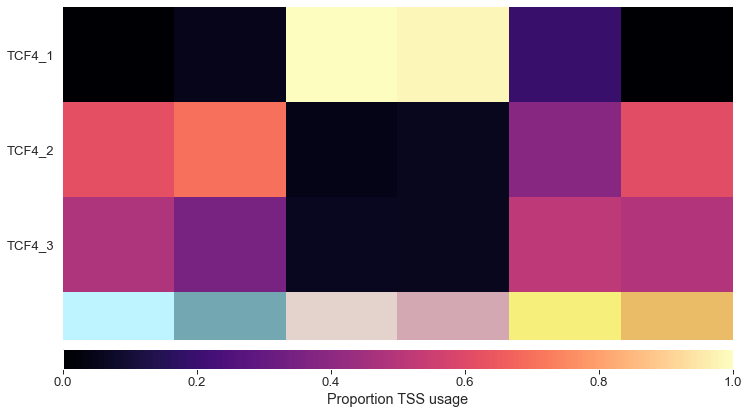

In [286]:
adata = sc.read('tss.h5ad')
groups = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
tss_df = plot_tss_heatmap(adata, groups, groups, 'TCF4', 'figures/tss')

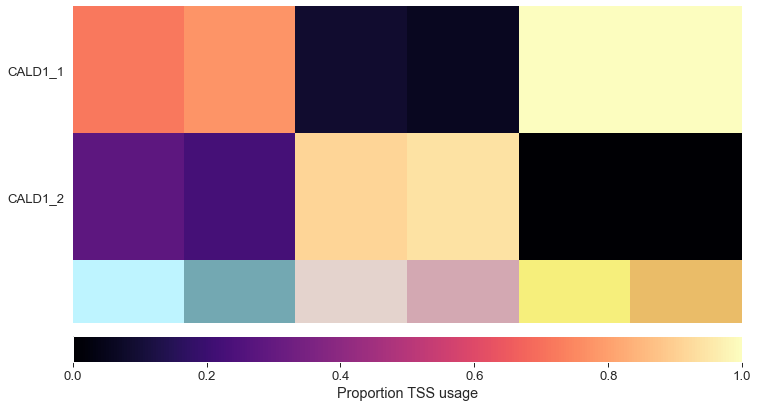

In [288]:
adata = sc.read('tss.h5ad')
groups = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
tss_df = plot_tss_heatmap(adata, groups, groups, 'CALD1', 'figures/tss')

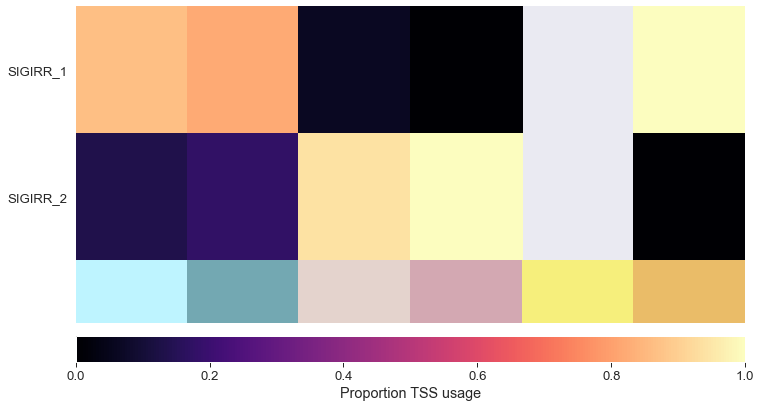

In [289]:
adata = sc.read('tss.h5ad')
groups = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
tss_df = plot_tss_heatmap(adata, groups, groups, 'SIGIRR', 'figures/tss')

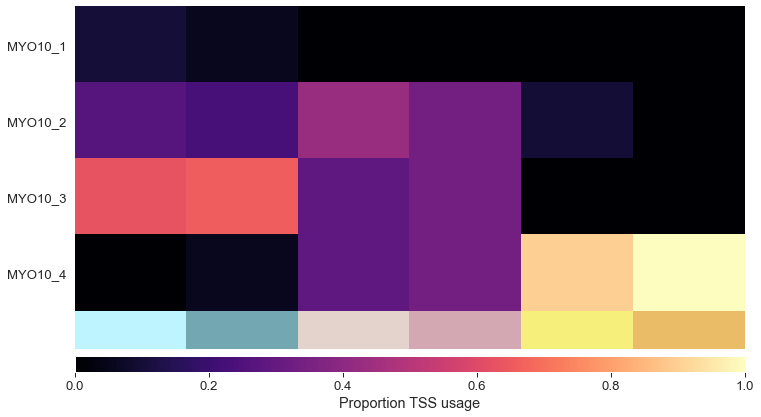

In [290]:
adata = sc.read('tss.h5ad')
groups = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
tss_df = plot_tss_heatmap(adata, groups, groups, 'MYO10', 'figures/tss')

### Isoform switching

In [5]:
pass_list = 'talon/pgp1_pass_list.csv'
ab_file = 'talon/pgp1_talon_abundance.tsv'
cond_map = {'Astrocytes': ['astro_1', 'astro_2'], \
            'Excitatory neurons': ['excite_neuron_1', 'excite_neuron_2'], \
            'PGP1': ['pgp1_1', 'pgp1_2']}

df = pd.read_csv(ab_file, sep='\t')
adata = make_adata(df, cond_map, pass_list=pass_list)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
Transforming to str index.
Transforming to str index.


In [6]:
# do one test for each pair of conditions
tested = []
conditions = ['Astrocytes', 'Excitatory neurons', 'PGP1']

how = 'iso'
for c1 in conditions:
    for c2 in conditions: 
        if (c1, c2) in tested or c1 == c2 or (c2, c1) in tested:
            continue
        else:
            tested.append((c1,c2))
        df = get_die(adata, [c1, c2], how=how, rc=10)
        fname = '{}_{}_{}_die.tsv'.format(c1, c2, how)
        df.to_csv(fname, sep='\t', index=False)

In [8]:
tested = []
p = 0.05
dpi = 10
how = 'iso'
conditions = ['Astrocytes', 'Excitatory neurons', 'PGP1']
for c1 in conditions:
    for c2 in conditions: 
        if (c1, c2) in tested or c1 == c2 or (c2, c1) in tested:
            continue
        else:
            tested.append((c1,c2))
        fname = '{}_{}_{}_die.tsv'.format(c1, c2, how)
        df = pd.read_csv(fname, sep='\t')
        df = filter_die_results(df, p, dpi)
        fname = '{}_{}_{}_sig_die.tsv'.format(c1, c2, how)
        df.to_csv(fname, sep='\t')

In [18]:
# make some swan reports of DIE isos 

# look at top significant ones and splicing factors
sg = swan.SwanGraph('swan.p')

tested = []

how = 'iso'
conditions = ['Astrocytes', 'Excitatory neurons', 'PGP1']
for c1 in conditions:
    for c2 in conditions: 
        if (c1, c2) in tested or c1 == c2 or (c2, c1) in tested:
            continue
        else:
            tested.append((c1,c2))
        fname = '{}_{}_{}_sig_die.tsv'.format(c1, c2, how)
        df = pd.read_csv(fname, sep='\t')
        
        # sort by dpi
        df = df.sort_values(by='dpi', ascending=False)
        for gname in df['index'].tolist()[:5]:
            
            # dpi swangraph
            sg.gen_report(gname, prefix='figures/{}_dpi'.format(gname),
                heatmap=True, 
                dpi=True, 
                cmap='magma', 
                indicate_novel=True,
                novelty=True)
            
            # tpm swangraph
            sg.gen_report(gname, prefix='figures/{}'.format(gname),
                heatmap=True, 
                cmap='viridis', 
                indicate_novel=True,
                novelty=True)

Graph from swan.p loaded

Plotting transcripts for ENSG00000161203.13
Saving transcript path graph for ENST00000382456.7 as figures/AP2M1_dpi_novel_ENST00000382456.7_path.png
Saving transcript path graph for ENCODEHT000422582 as figures/AP2M1_dpi_novel_ENCODEHT000422582_path.png
Saving transcript path graph for ENST00000439647.5 as figures/AP2M1_dpi_novel_ENST00000439647.5_path.png
Saving transcript path graph for ENST00000461733.5 as figures/AP2M1_dpi_novel_ENST00000461733.5_path.png
Saving transcript path graph for ENST00000466598.5 as figures/AP2M1_dpi_novel_ENST00000466598.5_path.png
Generating report for ENSG00000161203.13

Plotting transcripts for ENSG00000161203.13
Saving transcript path graph for ENST00000382456.7 as figures/AP2M1_novel_ENST00000382456.7_path.png
Saving transcript path graph for ENCODEHT000422582 as figures/AP2M1_novel_ENCODEHT000422582_path.png
Saving transcript path graph for ENST00000439647.5 as figures/AP2M1_novel_ENST00000439647.5_path.png
Saving transcrip

In [37]:
sg = swan.SwanGraph('swan.p')
datasets = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
gnames = ['TPD52L2', 'AP2M1', 'SRSF3', 'SRSF7']
for gname in gnames:

    # dpi swangraph
    sg.gen_report(gname, prefix='figures/{}_dpi'.format(gname),
        datasets=datasets,
        heatmap=True, 
        dpi=True, 
        cmap='magma', 
        indicate_novel=True,
        novelty=True)

    # tpm swangraph
    sg.gen_report(gname, prefix='figures/{}'.format(gname),
        datasets=datasets,
        heatmap=True, 
        cmap='viridis', 
        indicate_novel=True,
        novelty=True)

Graph from swan.p loaded

Plotting transcripts for ENSG00000101150.17
Saving transcript path graph for ENST00000346249.8 as figures/TPD52L2_dpi_novel_ENST00000346249.8_path.png
Saving transcript path graph for ENST00000348257.9 as figures/TPD52L2_dpi_novel_ENST00000348257.9_path.png
Saving transcript path graph for ENST00000358548.4 as figures/TPD52L2_dpi_novel_ENST00000358548.4_path.png
Saving transcript path graph for ENST00000352482.8 as figures/TPD52L2_dpi_novel_ENST00000352482.8_path.png
Saving transcript path graph for ENST00000217121.9 as figures/TPD52L2_dpi_novel_ENST00000217121.9_path.png
Saving transcript path graph for ENST00000351424.8 as figures/TPD52L2_dpi_novel_ENST00000351424.8_path.png
Saving transcript path graph for ENST00000474176.2 as figures/TPD52L2_dpi_novel_ENST00000474176.2_path.png
Generating report for ENSG00000101150.17

Plotting transcripts for ENSG00000101150.17
Saving transcript path graph for ENST00000346249.8 as figures/TPD52L2_novel_ENST00000346249.8_p

In [39]:
# tpm swangraph
gname = 'TPD52L2'
sg.gen_report(gname, prefix='figures/{}'.format(gname),
    datasets=datasets,
    heatmap=True,
              dpi=True,
    cmap='magma', 
              browser=True,
    novelty=True)


Plotting transcripts for ENSG00000101150.17
Saving transcript path graph for ENST00000346249.8 as figures/TPD52L2_browser_ENST00000346249.8_path.png
Saving transcript path graph for ENST00000348257.9 as figures/TPD52L2_browser_ENST00000348257.9_path.png
Saving transcript path graph for ENST00000358548.4 as figures/TPD52L2_browser_ENST00000358548.4_path.png
Saving transcript path graph for ENST00000352482.8 as figures/TPD52L2_browser_ENST00000352482.8_path.png
Saving transcript path graph for ENST00000217121.9 as figures/TPD52L2_browser_ENST00000217121.9_path.png
Saving transcript path graph for ENST00000351424.8 as figures/TPD52L2_browser_ENST00000351424.8_path.png
Saving transcript path graph for ENST00000474176.2 as figures/TPD52L2_browser_ENST00000474176.2_path.png
Generating report for ENSG00000101150.17


In [21]:
# splicing factors
gnames = ['SRSF2', 'SRSF3', 'SRSF7', 'SRSF8', 'SRSF11']

for gname in gnames:
    # dpi swangraph
    sg.gen_report(gname, prefix='figures/{}_dpi'.format(gname),
        heatmap=True, 
        dpi=True, 
        cmap='magma', 
        indicate_novel=True,
        novelty=True)

    # tpm swangraph
    sg.gen_report(gname, prefix='figures/{}'.format(gname),
        heatmap=True, 
        cmap='viridis', 
        indicate_novel=True,
        novelty=True)


Plotting transcripts for ENSG00000161547.16
Saving transcript path graph for ENST00000359995.9 as figures/SRSF2_dpi_novel_ENST00000359995.9_path.png
Saving transcript path graph for ENST00000392485.2 as figures/SRSF2_dpi_novel_ENST00000392485.2_path.png
Saving transcript path graph for ENST00000585202.5 as figures/SRSF2_dpi_novel_ENST00000585202.5_path.png
Saving transcript path graph for ENST00000452355.7 as figures/SRSF2_dpi_novel_ENST00000452355.7_path.png
Saving transcript path graph for ENST00000586778.1 as figures/SRSF2_dpi_novel_ENST00000586778.1_path.png
Saving transcript path graph for ENST00000582449.5 as figures/SRSF2_dpi_novel_ENST00000582449.5_path.png
Generating report for ENSG00000161547.16

Plotting transcripts for ENSG00000161547.16
Saving transcript path graph for ENST00000359995.9 as figures/SRSF2_novel_ENST00000359995.9_path.png
Saving transcript path graph for ENST00000392485.2 as figures/SRSF2_novel_ENST00000392485.2_path.png
Saving transcript path graph for ENST

### Genome browser track to color reads by their sample of origin

```bash
module load samtools
```

In [7]:
import os
import shlex
import pandas as pd
import subprocess

def make_bam_hub_entry(df, c_dict, ofile):
    with open(ofile, 'w') as o:
        for ind, e in df.iterrows():
            c = c_dict[e['sample']]
            c = c.lstrip('#')
            c = tuple(int(c[i:i+2], 16) for i in (0, 2, 4))

            s = 'track {}_reads\n'.format(e['sample'])
            s += 'bigDataUrl {}\n'.format(e.url)
            s += 'shortLabel {}_reads\n'.format(e['sample'])
            s += 'longLabel {}_reads\n'.format(e['sample'])
            s += 'type bam\n'
            s += 'visibility squish\n'
            s += 'bamColorMode off\n'
            s += 'color {},{},{}\n\n'.format(c[0],c[1],c[2])
            o.write(s)

# "input"
url = 'http://crick.bio.uci.edu/freese/210413_pgp1_hub/'
c_dict = {'astro_1': '#f6ef7c', 'astro_2': '#eabc68',\
          'excite_neuron_1': '#e4d3cd', 'excite_neuron_2': '#d3a8b2',\
          'pgp1_1': '#bef4ff', 'pgp1_2': '#73a8b2'}
config = 'talon/config.csv'
genome = 'hg38'
hub_name = 'pgp1'
email = 'freese@uci.edu'
scp_location = 'freese@crick.bio.uci.edu:~/pub/210413_pgp1_hub/'


genomefile = 'hub/genomes.txt'
hubfile = 'hub/hub.txt'
hubfile_relative = 'hub.txt'
trackdb = 'hub/{}/trackDb.txt'.format(genome)
relative_trackdb = '{}/trackDb.txt'.format(genome)
relative_genome = 'genomes.txt'
try:
    os.makedirs(os.path.dirname(trackdb))
except:
    pass
df = pd.read_csv(config, header=None, names=['sample', 'condition', \
                                             'platform', 'filepath'])
df['url'] = df.apply(lambda x: url+x['sample']+'.bam', axis=1)
df['local_loc'] = df.apply(lambda x: 'talon_tmp/'+x['sample']+'.bam', axis=1)

for ind, entry in df.iterrows():
    cmd = 'samtools index {}'.format(entry.local_loc)
    print(cmd)
    cmd = shlex.split(cmd)
    result = subprocess.run(cmd)  
    
    cmd = 'scp {} {}'.format(entry.local_loc, scp_location)
    cmd = shlex.split(cmd)
    print(cmd)
    result = subprocess.run(cmd)
    
    cmd = 'scp {}.bai {}'.format(entry.local_loc, scp_location)
    cmd = shlex.split(cmd)
    print(cmd)
    result = subprocess.run(cmd)
    
    
make_bam_hub_entry(df, c_dict, trackdb)

with open(genomefile, 'w') as o:
    s = 'genome {}\n'.format(genome)
    s += 'trackDb {}\n'.format(relative_trackdb)
    o.write(s)

with open(hubfile, 'w') as o:
    s = 'hub {}\n'.format(hub_name)
    s += 'shortLabel {}\n'.format(hub_name)
    s += 'longLabel {}\n'.format(hub_name)
    s += 'genomesFile {}\n'.format(relative_genome)
    s += 'email {}\n'.format(email)
    o.write(s)

cmd = 'scp -r hub/* {}'.format(scp_location)
cmd = shlex.split(cmd)
result = subprocess.run(cmd)

```bash
scp -r hub/ freese@crick.bio.uci.edu:~/pub/210413_pgp1_hub/
```